In [20]:
import numpy as np
import astropy.units as u
import time
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))
import poppy
import skimage
from skimage.registration import phase_cross_correlation
import copy
from importlib import reload
import matplotlib.pyplot as plt


import magpyx
from magpyx.utils import ImageStream
import purepyindi
from purepyindi import INDIClient
client0 = purepyindi.INDIClient('localhost', 7624)
client0.start()

from math_module import xp, xcipy, np_array
import utils
import fsm_utils
import cam_utils
from imshows import imshow1, imshow2, imshow3
from matplotlib.patches import Circle

wavelength = 633e-9
fl = 500e-3
fsm_pupil_diam = 7.1e-3
as_per_lamD = (wavelength/fsm_pupil_diam*u.radian).to(u.arcsec)
print(as_per_lamD)

pxscl_lamD = 3.45e-6 / (fl * wavelength/fsm_pupil_diam)
print(1/pxscl_lamD)

v_bias = np.array([[50,50,50]]).T

pxscl_lamD * as_per_lamD

18.389524275269295 arcsec
12.921004286589099


<Quantity 1.42322716 arcsec>

In [11]:
fsm = ImageStream('fsm')
fsm.write(v_bias)

In [17]:
pxscl_lamD * as_per_lamD

<Quantity 1.42322716 arcsec>

# Requirement for resolution

In [21]:
total_pupil_diam = 2.43*u.m
wavelength = 633*u.nm
fsm_pupil_diam = 9.4*u.mm
as_per_lamD = ((wavelength/fsm_pupil_diam)*u.radian).to(u.arcsec)

tt_at_fsm_pupil_rms = 4*u.nm
print(tt_at_fsm_pupil_rms.to(u.nm))

tt_pv_to_rms = 1/4
tt_at_fsm_pupil_pv =  tt_at_fsm_pupil_rms / tt_pv_to_rms
print(tt_at_fsm_pupil_pv.to(u.nm))

tt_at_fsm_pupil = np.arctan(tt_at_fsm_pupil_pv.to_value(u.m) / fsm_pupil_diam.to_value(u.m)) * u.radian
mag = (total_pupil_diam/fsm_pupil_diam).decompose()
tt_at_m1_pupil = tt_at_fsm_pupil/mag
print(tt_at_fsm_pupil.to(u.mas), tt_at_m1_pupil.to(u.mas))

fsm_res = (0.05*u.microradian).to(u.mas)
print(fsm_res)

res_req = tt_at_fsm_pupil.to(u.arcsec)
print(res_req)



4.0 nm
16.0 nm
351.0890319096121 mas 1.3581221810495285 mas
10.313240312354818 mas
0.3510890319096122 arcsec


In [22]:
res_req / as_per_lamD / pxscl_lamD

<Quantity 0.32659726>

In [9]:
amp = res_req

freq = 1*u.Hz
t_max = (1/freq).to(u.s)
Nsamps = 37
times = np.linspace(0, t_max, Nsamps)
delt = (times[1]-times[0]).to_value(u.s)

wave = amp*np.sin(2*np.pi*freq.to_value(u.Hz)*times.to_value(u.s))/np.sqrt(2)
volt_commands = np.zeros((Nsamps, 3, 1))
for i in range(Nsamps):
    volt_commands[i] = fsm_utils.get_fsm_volts(tip=wave[i], tilt=0*u.arcsec)
    # volt_commands[i] = fsm_utils.get_fsm_volts(tip=0*u.arcsec, tilt=wave[i])

Displacements: A = 5.00e-06 m, 5.00e-06 m, 5.00e-06 m. 
Delta Voltages: A = 50.00, B = 50.00, C = 50.00. 
Displacements: A = 5.00e-06 m, 5.00e-06 m, 5.00e-06 m. 
Delta Voltages: A = 50.01, B = 49.99, C = 49.99. 
Displacements: A = 5.00e-06 m, 5.00e-06 m, 5.00e-06 m. 
Delta Voltages: A = 50.03, B = 49.99, C = 49.99. 
Displacements: A = 5.00e-06 m, 5.00e-06 m, 5.00e-06 m. 
Delta Voltages: A = 50.04, B = 49.98, C = 49.98. 
Displacements: A = 5.01e-06 m, 5.00e-06 m, 5.00e-06 m. 
Delta Voltages: A = 50.05, B = 49.97, C = 49.97. 
Displacements: A = 5.01e-06 m, 5.00e-06 m, 5.00e-06 m. 
Delta Voltages: A = 50.06, B = 49.97, C = 49.97. 
Displacements: A = 5.01e-06 m, 5.00e-06 m, 5.00e-06 m. 
Delta Voltages: A = 50.07, B = 49.96, C = 49.96. 
Displacements: A = 5.01e-06 m, 5.00e-06 m, 5.00e-06 m. 
Delta Voltages: A = 50.08, B = 49.96, C = 49.96. 
Displacements: A = 5.01e-06 m, 5.00e-06 m, 5.00e-06 m. 
Delta Voltages: A = 50.08, B = 49.96, C = 49.96. 
Displacements: A = 5.01e-06 m, 5.00e-06 m, 5.0

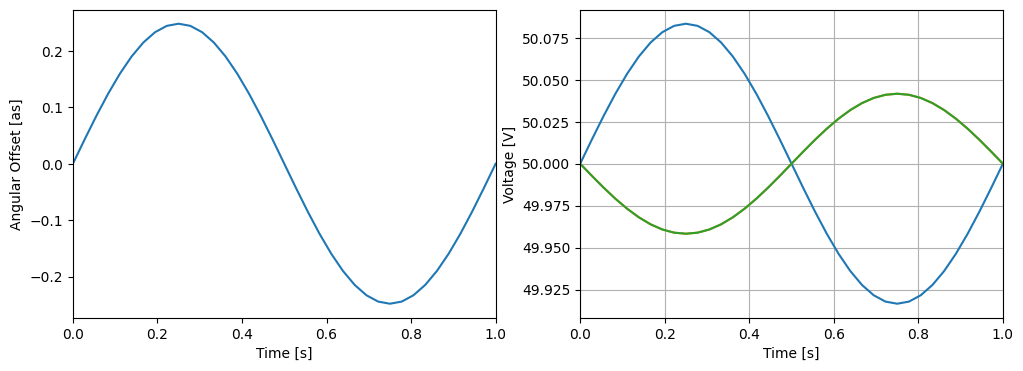

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(times, wave)
plt.xlim([0, t_max.to_value(u.s)])
plt.xlabel('Time [s]')
plt.ylabel('Angular Offset [as]')
# plt.grid()
# plt.show()

plt.subplot(122)
plt.plot(times, volt_commands[:,0])
plt.plot(times, volt_commands[:,1])
plt.plot(times, volt_commands[:,2])
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.xlim([0, t_max.to_value(u.s)])
plt.grid()
plt.show()

In [13]:
freq = 1 * Nsamps
try:
    print('Modulating FSM ...')
    i = 0
    while i<Nsamps+1:
        if i==Nsamps:
            i = 0
        fsm.write(volt_commands[i])
        time.sleep(1/freq)
        i += 1
except KeyboardInterrupt:
    print('FSM modulation stopped!')
    fsm.write(v_bias)
    time.sleep(0.25)

Modulating FSM ...
FSM modulation stopped!
